In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import scipy.stats
from scipy.stats import norm, gamma
from dfply import *

In [2]:
# 환경설정
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 데이터 불러오기
benz = pd.read_excel('data/carlist_benz_20200417.xlsx')

In [4]:
# 데이터 가공
benz_mod = benz >> \
    drop(X.link) >> \
    mask(~X.prc.str.contains('승계') | ~X.prc.str.contains('홈서비스')) >> \
    mask(~X.name2.str.contains('기타') | ~X.name2.str.contains('190-클래스') | ~X.name2.str.contains('스프린터')) >> \
    mutate(yer_mod=("20"+X.yer.str.slice(0,2)).astype(int)) >> \
    mutate(mon_mod=X.yer.str.slice(3,5).astype(int)) >> \
    mutate(earned_months=12*(2020-X.yer_mod)+(4-X.mon_mod)+0.5) >> \
    mask((X.yer_mod>=2013) & (X.yer_mod<=2020)) >> \
    mutate(prc_mod=X.prc.str.replace('만원', '').str.replace(',', '').astype(int)) >> \
    mutate(km_mod=X.km.str.replace('km', '').str.replace(',', '').astype(int)) >> \
    mask(~X.fue.str.contains('전기')) >> \
    mask(X.prc_mod < 20000) >> \
    drop(X.yer, X.km, X.mon_mod, X.prc, X['name1'], X['name4'], X['loc'], X.ins, X.ass) >> \
    rename(name = X['name2'], name2=X['name3'], yer=X.yer_mod, prc=X.prc_mod, km=X.km_mod) >> \
    mutate(km_per_yer=X.km/X.earned_months*12) >> \
    mutate(log_prc=X.prc.apply(lambda x: np.log(x)))
    
benz_mod = benz_mod.reset_index(drop=True)
benz_mod.head()

,name,name2,fue,yer,earned_months,prc,km,km_per_yer,log_prc
0,E-클래스 W213,E220d 4MATIC 아방가르드,디젤,2016,42.5,4850,37500,10588.235294,8.486734
1,CLA-클래스 C117,CLA45 AMG 4MATIC,가솔린,2015,55.5,3500,47000,10162.162162,8.160518
2,C-클래스 W204,C220 CDI 아방가르드,디젤,2013,81.5,1350,124300,18301.840491,7.207860
3,S-클래스 W222,S63 AMG 4MATIC+ 퍼포먼스 에디션,가솔린,2018,21.5,17900,28000,15627.906977,9.792556
4,E-클래스 W212,E300 엘레강스,가솔린,2013,77.5,2500,27858,4313.496774,7.824046


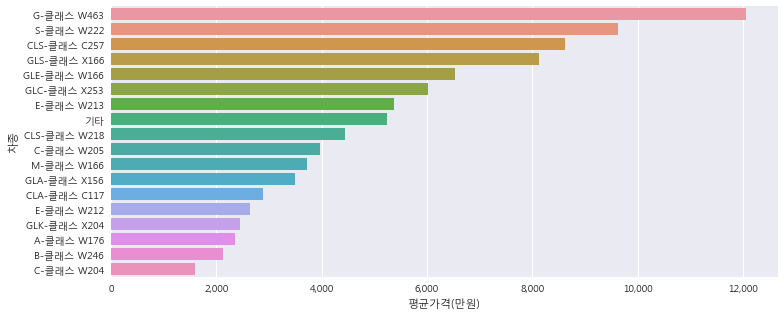

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(11,4.5))

# 차종별 물량
cnt_by_name = benz_mod.groupby('name').size().sort_values(ascending=False)
cnt_etc = cnt_by_name[17:].sum()
cnt_by_name = cnt_by_name[:17]
cnt_by_name['기타'] = cnt_etc
cnt_by_name = cnt_by_name.reset_index(name='num')
benz_mod['name_grp'] = benz_mod.name.copy()
benz_mod.loc[~benz_mod.name_grp.isin(cnt_by_name.name[:-1]), 'name_grp'] = '기타'

# 차종별 가격(평균)
prc_by_name = benz_mod.groupby('name_grp')['prc'].mean().sort_values(ascending=False)
prc_by_name = prc_by_name.reset_index(name='prc')
sns.barplot(y='name_grp', x='prc', data=prc_by_name, ax=ax)

plt.xlabel('평균가격(만원)')
plt.ylabel('차종')
plt.tight_layout()
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('fig1')
plt.show()

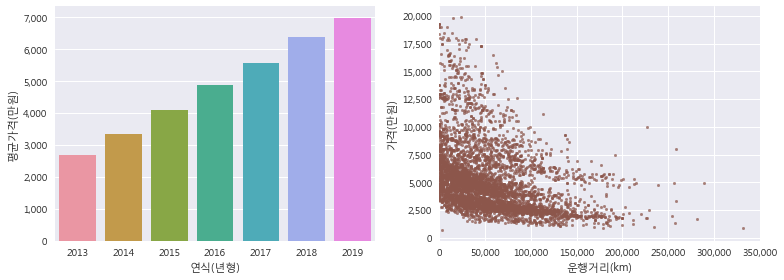

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(11,4))

# 연식별 가격(평균)
prc_by_yer = benz_mod.query('yer < 2020').groupby('yer')['prc'].mean()
prc_by_yer = prc_by_yer.reset_index(name='prc')
sns.barplot(x='yer', y='prc', data=prc_by_yer, ax=ax[0])

ax[0].set_xlabel('연식(년형)')
ax[0].set_ylabel('평균가격(만원)')
ax[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax[1].scatter(benz_mod['km'], benz_mod['prc'], s=7, color='#8c564b', alpha=0.75)
# sns.scatterplot(x='km', y='prc', hue='fue', data=benz_mod, ax=ax[1], s=30)
ax[1].set_xlabel('운행거리(km)')
ax[1].set_ylabel('가격(만원)')
ax[1].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax[1].set_xlim(0, 350000)

plt.tight_layout()
plt.savefig('fig2')
plt.show()

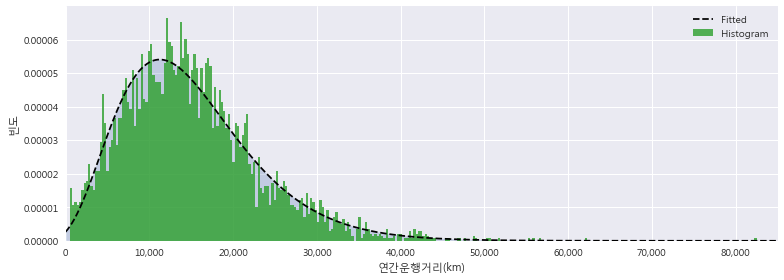

(4.848822920755021, -2933.7217867726395, 3682.857140938546)

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(11,4))

km_per_yer = benz_mod.query('km_per_yer > 500')['km_per_yer']
km_per_yer_model = getattr(scipy.stats, 'gamma')
params = km_per_yer_model.fit(km_per_yer)
km_per_yer_model = km_per_yer_model(*params[:-2], params[-2], params[-1])
x_range = np.linspace(0, 85000, 1000)
y_range = km_per_yer_model.pdf(x_range)

# 연간 운행거리 분포
ax.plot(x_range, y_range, 'k--', label='Fitted')
ax.fill_between(x_range, y_range, alpha=0.25)
ax.hist(km_per_yer, bins=300, alpha=0.8, color='#2ca02c', density=True, label='Histogram')
ax.legend()
ax.set_xlim(0, 85000)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('연간운행거리(km)')
ax.set_ylabel('빈도')
plt.tight_layout()
plt.savefig('fig3')
plt.show()
params
# np.percentile(km_per_yer, q=[5, 25, 50, 75, 95]), km_per_yer.mean(), km_per_yer.std()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

In [9]:
# 데이터 가공하기
benz_ml = benz_mod.query('name_grp != "기타"')
enc = OneHotEncoder(handle_unknown='ignore')

selected = ['name_grp', 'fue']

enc.fit(benz_ml[selected])
data = np.c_[enc.transform(benz_ml[selected]).toarray(), benz_ml[['earned_months', 'km']]]
target = benz_ml['log_prc'].values

train_X, test_X, train_y, test_y = train_test_split(data, target, test_size=0.1, random_state=20200429)

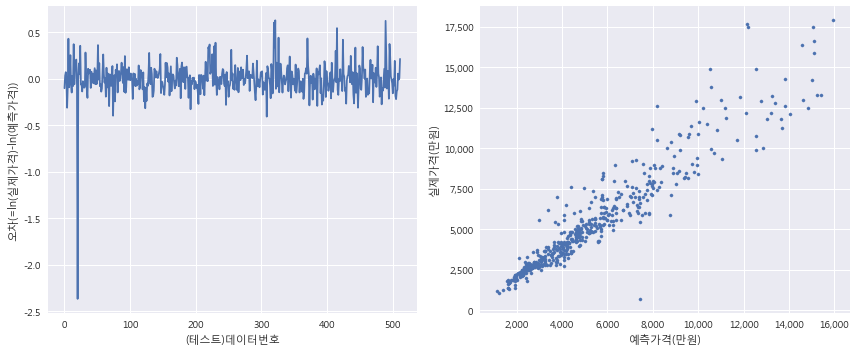

R^2: 0.894530880352514
-0.007922017407556213 -2.829821315881494e-06 0.18331383918179212


In [10]:
# Linear Regression
fig, ax = plt.subplots(1, 2, figsize=(12,5))

clf = LinearRegression()
clf.fit(train_X, train_y)
ax[0].plot(test_y-clf.predict(test_X))

ax[0].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax[0].set_xlabel('(테스트)데이터번호')
ax[0].set_ylabel('오차(=ln(실제가격)-ln(예측가격))')
plt.tight_layout()

ax[1].scatter(np.exp(clf.predict(test_X)), np.exp(test_y), s=10)
ax[1].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax[1].set_xlabel('예측가격(만원)')
ax[1].set_ylabel('실제가격(만원)')
plt.tight_layout()
plt.savefig('fig4')
plt.show()

print('R^2: {}'.format(clf.score(test_X, test_y)))
sigma = np.sqrt(np.sum((test_y-clf.predict(test_X))**2)/(len(test_y)-(len(clf.coef_)+1)))
beta_em, beta_km = clf.coef_[-2:]
print(beta_em, beta_km, sigma)
# , np.exp(beta_em*38+beta_km*14924*3) <- 이렇게 쓰면 그냥 출력됨

In [11]:
# 모수
beta_경과기간, beta_운행거리, eps = -0.007922, -2.830e-6, norm(loc=0, scale=0.1833)
d경과기간, d연간운행거리 = 38, gamma(a=4.849, loc=-2934, scale=3683)
매각할인율 = 0.3

In [12]:
n = 50000
np.random.seed(1)
dln차량가격 = beta_경과기간*d경과기간+beta_운행거리*3*d연간운행거리.rvs(n)+np.sqrt(2)*eps.rvs(n)
손해액 = np.fmax(0.3-np.exp(dln차량가격)*(1-매각할인율),0)

In [13]:
사고확률 = np.sum(손해액>0)/n
사고당평균보상률 = 손해액[손해액>0].mean()
사고확률, 사고당평균보상률, 사고확률*사고당평균보상률

(0.0587, 0.03173949763780664, 0.0018631085113392498)

In [14]:
잔존율_0 = np.exp(dln차량가격)*(1-0.0)*100
잔존율_20 = np.exp(dln차량가격)*(1-0.2)*100
잔존율_30 = np.exp(dln차량가격)*(1-0.3)*100
잔존율_40 = np.exp(dln차량가격)*(1-0.4)*100
잔존율_60 = np.exp(dln차량가격)*(1-0.6)*100

손해액_0 = np.fmax(30-잔존율_0, 0)
손해액_20 = np.fmax(30-잔존율_20, 0)
손해액_30 = np.fmax(30-잔존율_30, 0)
손해액_40 = np.fmax(30-잔존율_40, 0)
손해액_60 = np.fmax(30-잔존율_60, 0)

사고확률_0 = np.sum(손해액_0>0)/n
사고확률_20 = np.sum(손해액_20>0)/n
사고확률_30 = np.sum(손해액_30>0)/n
사고확률_40 = np.sum(손해액_40>0)/n
사고확률_60 = np.sum(손해액_60>0)/n

사고당평균보상률_0 = 손해액_0[손해액_0>0].mean()
사고당평균보상률_20 = 손해액_20[손해액_20>0].mean()
사고당평균보상률_30 = 손해액_30[손해액_30>0].mean()
사고당평균보상률_40 = 손해액_40[손해액_40>0].mean()
사고당평균보상률_60 = 손해액_60[손해액_60>0].mean()

In [15]:
print(np.mean(사고확률_0), np.mean(사고확률_20), np.mean(사고확률_30), np.mean(사고확률_40), np.mean(사고확률_60))
print(np.mean(사고당평균보상률_0), np.mean(사고당평균보상률_20), np.mean(사고당평균보상률_30), np.mean(사고당평균보상률_40), np.mean(사고당평균보상률_60))
print(np.mean(손해액_0), np.mean(손해액_20), np.mean(손해액_30), np.mean(손해액_40), np.mean(손해액_60))
print(np.mean(손해액_0)/1.15, np.mean(손해액_20)/1.15, np.mean(손해액_30)/1.15, np.mean(손해액_40)/1.15, np.mean(손해액_60)/1.15)

0.00202 0.01996 0.0587 0.16024 0.69694
2.3120558308570494 2.670356161179051 3.1739497637806653 3.7985043839107484 6.773849821064062
0.00467035277833124 0.053300308977133844 0.18631085113392507 0.6086723424778585 4.720966894292389
0.004061176328983687 0.046348094762725084 0.1620094357686305 0.5292802978068335 4.105188603732513


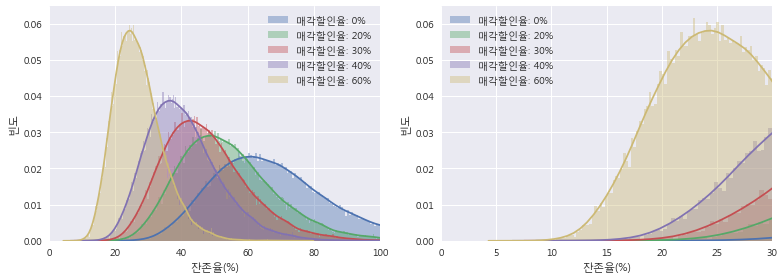

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(11,4))

sns.distplot(잔존율_0, bins=300, label='매각할인율: 0%', ax=ax[0])
sns.distplot(잔존율_20, bins=300, label='매각할인율: 20%', ax=ax[0])
sns.distplot(잔존율_30, bins=300, label='매각할인율: 30%', ax=ax[0])
sns.distplot(잔존율_40, bins=300, label='매각할인율: 40%', ax=ax[0])
sns.distplot(잔존율_60, bins=300, label='매각할인율: 60%', ax=ax[0])
ax[0].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0f}'))
ax[0].set_xlabel('잔존율(%)')
ax[0].set_ylabel('빈도')
ax[0].set_xlim(0,100)
ax[0].legend()

sns.distplot(잔존율_0, bins=300, label='매각할인율: 0%', ax=ax[1])
sns.distplot(잔존율_20, bins=300, label='매각할인율: 20%', ax=ax[1])
sns.distplot(잔존율_30, bins=300, label='매각할인율: 30%', ax=ax[1])
sns.distplot(잔존율_40, bins=300, label='매각할인율: 40%', ax=ax[1])
sns.distplot(잔존율_60, bins=300, label='매각할인율: 60%', ax=ax[1])
ax[1].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0f}'))
ax[1].set_xlabel('잔존율(%)')
ax[1].set_ylabel('빈도')
ax[1].set_xlim(0,30)
ax[1].legend()

plt.tight_layout()
plt.savefig('fig5')
plt.show()

In [17]:
with pd.ExcelWriter('result.xlsx', 'xlsxwriter') as writer:
    prc_by_name[['name_grp', 'prc']].to_excel(writer, sheet_name='차종별', index=False)
    prc_by_yer.to_excel(writer, sheet_name='연식별', index=False)